# Imports

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50

import pandas as pd
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm 

from PIL import Image
import os
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from sklearn.utils import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")





Using device: cpu


**FUNCTIONS**

In [2]:
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # lr = optimizer.param_groups[0]['lr']

        print(f"=====================================Epoch: {epoch + 1} / {num_epochs}=====================================")
        train_progress = tqdm(train_loader, total=len(train_loader), leave=True)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_progress.set_description(f'[TRAIN] ')
            
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        val_progress = tqdm(val_loader, total=len(val_loader), leave=True)
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0) # 1

                probs = F.softmax(outputs, dim=1) # 3
                _, predicted = torch.max(probs, 1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                val_progress.set_description(f'[VALID] ')

        val_loss /= len(val_loader.dataset) # 2
        val_acc = correct / total

        print(f'=> Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} |  Train Acc={train_acc:.4f},  Val Acc={val_acc:.4f}')

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # scheduler.step()

    
    return history

def test_model(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

def predict_image_with_debug(model, image_path, device, class_labels):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        logits = model(image)  # Raw logits from the model

    # Print raw logits before softmax
    print("Logits:", logits)

    # Calculate probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Plot class probabilities
    plt.bar(range(len(class_labels)), probabilities[0].cpu().numpy())
    plt.xticks(range(len(class_labels)), class_labels, rotation=90)
    plt.show()

    # Get predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    confidence = probabilities.max().item()
    prediction_time = time.time() - start_time

    return predicted_class, confidence, prediction_time

def plot_from_history(history, max_epochs):
    # Extract data from the history dictionary
    if isinstance(history['epoch'], range):
        # 'epoch' is a column in the DataFrame
        epochs = list(history['epoch'])[:max_epochs]
        train_losses = history['train_loss'][:max_epochs]
        val_losses = history['val_loss'][:max_epochs]
        train_accuracies = history['train_accuracy'][:max_epochs]
        val_accuracies = history['val_accuracy'][:max_epochs]

    elif isinstance(history['epoch'], list):
        # 'epoch' is a list
        epochs = history['epoch'][:max_epochs]
        train_losses = history['train_loss'][:max_epochs]
        val_losses = history['val_loss'][:max_epochs]
        train_accuracies = history['train_accuracy'][:max_epochs]
        val_accuracies = history['val_accuracy'][:max_epochs]
    else:
        # 'epoch' is a range object
        history_filtered = history[history['epoch'] <= max_epochs]
        epochs = history_filtered['epoch']
        train_losses = history_filtered['train_loss']
        val_losses = history_filtered['val_loss']
        train_accuracies = history_filtered['train_accuracy']
        val_accuracies = history_filtered['val_accuracy']

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)  # Add grid

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid

    # Save the plot
    plt.tight_layout()
    plt.show()
def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    return df



# Dataset Preparation

In [4]:
# FOR NOT ENHANCED
train_dir = './DATASET/TRAIN'
test_dir = './DATASET/TEST - mergedval'
validation_dir = './DATASET/VALIDATION'

# FOR ENHANCED + UNET
enhancedtrain_dir = './DATASET/TRAIN_ESRGAN_UNET'
enhancedtest_dir = './DATASET/TEST_ESRGAN_UNET - mergedval'
enhancedval_dir = './DATASET/VALIDATION_ESRGAN_UNET'

# FOR ENHANCED
# enhancedtrain_dir = './DATASET/TRAIN_ESRGAN2 - ESRGAN'
# enhancedtest_dir = './DATASET/TEST_ESRGAN2 - ESRGAN-mergedval'
# enhancedval_dir = './DATASET/VALIDATION_ESRGAN2 - ESRGAN'

# SET SEED 42 FOR REPLICABILITY (SAME TRAIN RESULT EVEN RUN MULTIPLE TIMES OR ON DIFFERENT DEVICES) !Add to docs!
seed = 42
np.random.seed(seed)
random.seed(seed)


**PYTORCH**

In [5]:
# Hyperparameters
img_height, img_width = 224, 224
batch_size = 16
learning_rate = 0.001
epochs = 30

# SET SEED FOR REPRODUCIBILITY
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  

# Data augmentation and normalization for training
augmented_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2), shear=5),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

unaugmented_transform = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# ORIGINAL datasets
train_dataset = datasets.ImageFolder(train_dir, transform=unaugmented_transform) # NOT AUGMENTED
val_dataset = datasets.ImageFolder(validation_dir, transform=unaugmented_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=unaugmented_transform)

# ENHANCED datasets
enhanced_train_dataset = datasets.ImageFolder(enhancedtrain_dir, transform=unaugmented_transform) # NOT AUGMENTED
val_dataset = datasets.ImageFolder(validation_dir, transform=unaugmented_transform)
enhanced_val_dataset = datasets.ImageFolder(enhancedval_dir, transform=unaugmented_transform)
enhanced_test_dataset = datasets.ImageFolder(enhancedtest_dir, transform=unaugmented_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

y_true = [sample[1] for sample in train_dataset.samples] 

# Compute class weights based on the class distribution in y_true
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_true), y=y_true)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

#>>>>> HIGH IMAGE COUNT = HIGH WEIGHT VALUE
#>>>>> HIGHER WEIGHT VALUE = HIGH TRAINING IMPORTANCE ON THAT CLASS (Model will focus more on that class)
#>>>>> 0 is low importance, higher value is high importance
#>>>>> ASK GPT
print(f"Class weights: {class_weights}")

print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

print(f"Number of images in enhanced training set: {len(enhanced_train_dataset)}")
print(f"Number of images in enhanced validation set: {len(enhanced_val_dataset)}")
print(f"Number of images in enhanced test set: {len(enhanced_test_dataset)}")


Class weights: [1.37173203 0.60569986 3.33134921 0.89690171 0.70133668 0.55193951
 3.2164751  0.64329502 0.29611993 9.32777778 0.44207478 4.66388889
 0.73447069 2.39173789 2.74346405 5.4869281  6.66269841 1.50448029]
Number of images in training set: 1679
Number of images in validation set: 474
Number of images in test set: 720
Number of images in enhanced training set: 1679
Number of images in enhanced validation set: 474
Number of images in enhanced test set: 720


# PYTORCH (BASELINE)

In [6]:



torch_baseline = resnet50(weights="IMAGENET1K_V1").to(device)

# FREEZE ALL LAYERS
for param in torch_baseline.parameters():
    param.requires_grad = False

class BaselineResNet(nn.Module):
    def __init__(self, base_model, num_classes=18):
        super(BaselineResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        x = self.fc(gap)
        return x


torch_baseline_model = BaselineResNet(torch_baseline).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # add to docs about using balanced class weights for imbalanced dataset refer at Function in Import section
optimizer = optim.Adamax(torch_baseline_model.fc.parameters(), lr=learning_rate)

for name, layer in torch_baseline_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')



: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [ ]:
# NOT Enhanced No Augmentation 70:30 split
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]


=> Train Loss=2.4544, Val Loss=1.5498 |  Train Acc=0.4592,  Val Acc=0.7222
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:30<00:00,  1.48it/s]


=> Train Loss=1.6606, Val Loss=1.1435 |  Train Acc=0.7772,  Val Acc=0.8097
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:31<00:00,  1.42it/s]


=> Train Loss=1.2936, Val Loss=0.9673 |  Train Acc=0.8362,  Val Acc=0.8444
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


=> Train Loss=1.0832, Val Loss=0.8244 |  Train Acc=0.8565,  Val Acc=0.8514
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


=> Train Loss=0.9116, Val Loss=0.7070 |  Train Acc=0.8749,  Val Acc=0.8708
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


=> Train Loss=0.7959, Val Loss=0.6211 |  Train Acc=0.8892,  Val Acc=0.8847
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.94it/s]


=> Train Loss=0.7040, Val Loss=0.5931 |  Train Acc=0.9017,  Val Acc=0.8917
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]


=> Train Loss=0.6524, Val Loss=0.5278 |  Train Acc=0.9059,  Val Acc=0.8986
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.03it/s]


=> Train Loss=0.5776, Val Loss=0.4924 |  Train Acc=0.9119,  Val Acc=0.9014
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.80it/s]


=> Train Loss=0.5333, Val Loss=0.4622 |  Train Acc=0.9130,  Val Acc=0.9083
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.09it/s]


=> Train Loss=0.4749, Val Loss=0.4345 |  Train Acc=0.9279,  Val Acc=0.9208
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.03it/s]


=> Train Loss=0.4706, Val Loss=0.4456 |  Train Acc=0.9214,  Val Acc=0.9014
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.16it/s]


=> Train Loss=0.4239, Val Loss=0.4090 |  Train Acc=0.9202,  Val Acc=0.9069
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


=> Train Loss=0.3764, Val Loss=0.3701 |  Train Acc=0.9375,  Val Acc=0.9208
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.74it/s]


=> Train Loss=0.3663, Val Loss=0.3676 |  Train Acc=0.9375,  Val Acc=0.9097
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.23it/s]


=> Train Loss=0.3606, Val Loss=0.3716 |  Train Acc=0.9369,  Val Acc=0.9056
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.08it/s]


=> Train Loss=0.3428, Val Loss=0.3457 |  Train Acc=0.9345,  Val Acc=0.9236
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


=> Train Loss=0.3239, Val Loss=0.3203 |  Train Acc=0.9381,  Val Acc=0.9306
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


=> Train Loss=0.3062, Val Loss=0.3116 |  Train Acc=0.9369,  Val Acc=0.9319
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


=> Train Loss=0.2812, Val Loss=0.3126 |  Train Acc=0.9434,  Val Acc=0.9306
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


=> Train Loss=0.2696, Val Loss=0.2967 |  Train Acc=0.9494,  Val Acc=0.9292
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.14it/s]


=> Train Loss=0.2738, Val Loss=0.2997 |  Train Acc=0.9392,  Val Acc=0.9292
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.15it/s]


=> Train Loss=0.2431, Val Loss=0.2789 |  Train Acc=0.9535,  Val Acc=0.9333
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


=> Train Loss=0.2484, Val Loss=0.2882 |  Train Acc=0.9422,  Val Acc=0.9347
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.97it/s]


=> Train Loss=0.2429, Val Loss=0.2740 |  Train Acc=0.9506,  Val Acc=0.9292
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


=> Train Loss=0.2345, Val Loss=0.2729 |  Train Acc=0.9482,  Val Acc=0.9347
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.98it/s]


=> Train Loss=0.2274, Val Loss=0.2683 |  Train Acc=0.9547,  Val Acc=0.9389
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.00it/s]


=> Train Loss=0.2115, Val Loss=0.2579 |  Train Acc=0.9535,  Val Acc=0.9361
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.89it/s]


=> Train Loss=0.1991, Val Loss=0.2664 |  Train Acc=0.9577,  Val Acc=0.9361
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.01it/s]

=> Train Loss=0.1911, Val Loss=0.2592 |  Train Acc=0.9565,  Val Acc=0.9361


In [ ]:
# ENHANCED No Augmentation 70:30 split
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


=> Train Loss=2.4885, Val Loss=1.6751 |  Train Acc=0.4753,  Val Acc=0.7014
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


=> Train Loss=1.7157, Val Loss=1.2211 |  Train Acc=0.7570,  Val Acc=0.8028
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=1.3342, Val Loss=1.0580 |  Train Acc=0.8350,  Val Acc=0.8153
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


=> Train Loss=1.1161, Val Loss=0.8437 |  Train Acc=0.8553,  Val Acc=0.8639
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


=> Train Loss=0.9691, Val Loss=0.7409 |  Train Acc=0.8731,  Val Acc=0.8778
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


=> Train Loss=0.8252, Val Loss=0.6651 |  Train Acc=0.8839,  Val Acc=0.8819
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


=> Train Loss=0.7573, Val Loss=0.6276 |  Train Acc=0.8827,  Val Acc=0.8833
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


=> Train Loss=0.6582, Val Loss=0.5760 |  Train Acc=0.8999,  Val Acc=0.8847
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


=> Train Loss=0.6011, Val Loss=0.5446 |  Train Acc=0.9065,  Val Acc=0.8986
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


=> Train Loss=0.5419, Val Loss=0.4884 |  Train Acc=0.9136,  Val Acc=0.9069
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


=> Train Loss=0.5090, Val Loss=0.4532 |  Train Acc=0.9119,  Val Acc=0.9222
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


=> Train Loss=0.4756, Val Loss=0.4627 |  Train Acc=0.9172,  Val Acc=0.9125
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


=> Train Loss=0.4451, Val Loss=0.4184 |  Train Acc=0.9214,  Val Acc=0.9153
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


=> Train Loss=0.3951, Val Loss=0.4100 |  Train Acc=0.9381,  Val Acc=0.9153
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=0.3997, Val Loss=0.3778 |  Train Acc=0.9232,  Val Acc=0.9264
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.75it/s]


=> Train Loss=0.3598, Val Loss=0.3721 |  Train Acc=0.9357,  Val Acc=0.9125
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=0.3346, Val Loss=0.3703 |  Train Acc=0.9404,  Val Acc=0.9194
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


=> Train Loss=0.3365, Val Loss=0.3556 |  Train Acc=0.9351,  Val Acc=0.9250
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


=> Train Loss=0.3194, Val Loss=0.3485 |  Train Acc=0.9434,  Val Acc=0.9153
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.07it/s]


=> Train Loss=0.3123, Val Loss=0.3403 |  Train Acc=0.9375,  Val Acc=0.9222
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:29<00:00,  1.54it/s]


=> Train Loss=0.2839, Val Loss=0.3179 |  Train Acc=0.9381,  Val Acc=0.9306
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


=> Train Loss=0.2719, Val Loss=0.2943 |  Train Acc=0.9422,  Val Acc=0.9417
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


=> Train Loss=0.2669, Val Loss=0.3001 |  Train Acc=0.9470,  Val Acc=0.9444
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:37<00:00,  1.20it/s]


=> Train Loss=0.2541, Val Loss=0.2828 |  Train Acc=0.9482,  Val Acc=0.9417
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


=> Train Loss=0.2464, Val Loss=0.2782 |  Train Acc=0.9547,  Val Acc=0.9375
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.69it/s]


=> Train Loss=0.2420, Val Loss=0.2925 |  Train Acc=0.9482,  Val Acc=0.9375
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:28<00:00,  1.56it/s]


=> Train Loss=0.2318, Val Loss=0.2810 |  Train Acc=0.9529,  Val Acc=0.9389
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.69it/s]


=> Train Loss=0.2110, Val Loss=0.2714 |  Train Acc=0.9595,  Val Acc=0.9444
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]


=> Train Loss=0.1910, Val Loss=0.2681 |  Train Acc=0.9571,  Val Acc=0.9347
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.98it/s]

=> Train Loss=0.2123, Val Loss=0.2591 |  Train Acc=0.9535,  Val Acc=0.9458


In [ ]:
# ENHANCED + UNET No Augmentation 70:30 split
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


=> Train Loss=2.4509, Val Loss=1.6335 |  Train Acc=0.4556,  Val Acc=0.7250
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


=> Train Loss=1.6661, Val Loss=1.2386 |  Train Acc=0.7635,  Val Acc=0.8347
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=1.3393, Val Loss=0.9578 |  Train Acc=0.7999,  Val Acc=0.8583
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


=> Train Loss=1.1039, Val Loss=0.8861 |  Train Acc=0.8261,  Val Acc=0.8667
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


=> Train Loss=0.9282, Val Loss=0.7400 |  Train Acc=0.8600,  Val Acc=0.8861
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.8448, Val Loss=0.6614 |  Train Acc=0.8672,  Val Acc=0.8972
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


=> Train Loss=0.7461, Val Loss=0.6356 |  Train Acc=0.8809,  Val Acc=0.8931
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.6904, Val Loss=0.5526 |  Train Acc=0.8785,  Val Acc=0.8972
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.6231, Val Loss=0.4983 |  Train Acc=0.8916,  Val Acc=0.9083
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.5961, Val Loss=0.4973 |  Train Acc=0.8809,  Val Acc=0.9056
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.5335, Val Loss=0.4673 |  Train Acc=0.9023,  Val Acc=0.9111
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


=> Train Loss=0.5089, Val Loss=0.4210 |  Train Acc=0.8910,  Val Acc=0.9222
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.15it/s]


=> Train Loss=0.4892, Val Loss=0.4169 |  Train Acc=0.9023,  Val Acc=0.9167
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.4412, Val Loss=0.4042 |  Train Acc=0.9107,  Val Acc=0.9167
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


=> Train Loss=0.4275, Val Loss=0.3688 |  Train Acc=0.9113,  Val Acc=0.9292
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.25it/s]


=> Train Loss=0.4065, Val Loss=0.3808 |  Train Acc=0.9107,  Val Acc=0.9250
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


=> Train Loss=0.3959, Val Loss=0.3732 |  Train Acc=0.9095,  Val Acc=0.9278
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.3711, Val Loss=0.3581 |  Train Acc=0.9261,  Val Acc=0.9236
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


=> Train Loss=0.3601, Val Loss=0.3437 |  Train Acc=0.9214,  Val Acc=0.9250
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


=> Train Loss=0.3160, Val Loss=0.3153 |  Train Acc=0.9357,  Val Acc=0.9347
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


=> Train Loss=0.3141, Val Loss=0.3249 |  Train Acc=0.9345,  Val Acc=0.9333
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.3423, Val Loss=0.3075 |  Train Acc=0.9267,  Val Acc=0.9333
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


=> Train Loss=0.3064, Val Loss=0.3181 |  Train Acc=0.9214,  Val Acc=0.9292
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


=> Train Loss=0.2939, Val Loss=0.3075 |  Train Acc=0.9422,  Val Acc=0.9375
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.2946, Val Loss=0.3186 |  Train Acc=0.9315,  Val Acc=0.9208
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


=> Train Loss=0.2723, Val Loss=0.2879 |  Train Acc=0.9345,  Val Acc=0.9319
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


=> Train Loss=0.2823, Val Loss=0.2821 |  Train Acc=0.9291,  Val Acc=0.9375
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


=> Train Loss=0.2649, Val Loss=0.2803 |  Train Acc=0.9410,  Val Acc=0.9278
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


=> Train Loss=0.2580, Val Loss=0.2781 |  Train Acc=0.9333,  Val Acc=0.9417
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]

=> Train Loss=0.2539, Val Loss=0.2852 |  Train Acc=0.9369,  Val Acc=0.9347


# BASELINE RESULTS & VISUALIZATION

**REPORT**


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.96      0.83      0.89        30
 Acanthurus Nigrofuscus       0.88      0.80      0.84        64
   Balistapus Undulatus       0.91      0.77      0.83        13
 Canthigaster Valentini       0.88      1.00      0.93        43
 Chaetodon Trifascialis       0.91      0.89      0.90        57
   Hemigymnus Fasciatus       0.97      0.93      0.95        72
  Hemigymnus Melapterus       0.76      1.00      0.87        13
        Lutjanus fulvus       0.98      1.00      0.99        61
     Myripristis Kuntee       0.99      0.99      0.99       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       1.00      0.94      0.97        54
               Scaridae       0.71      0.88      0.79        17


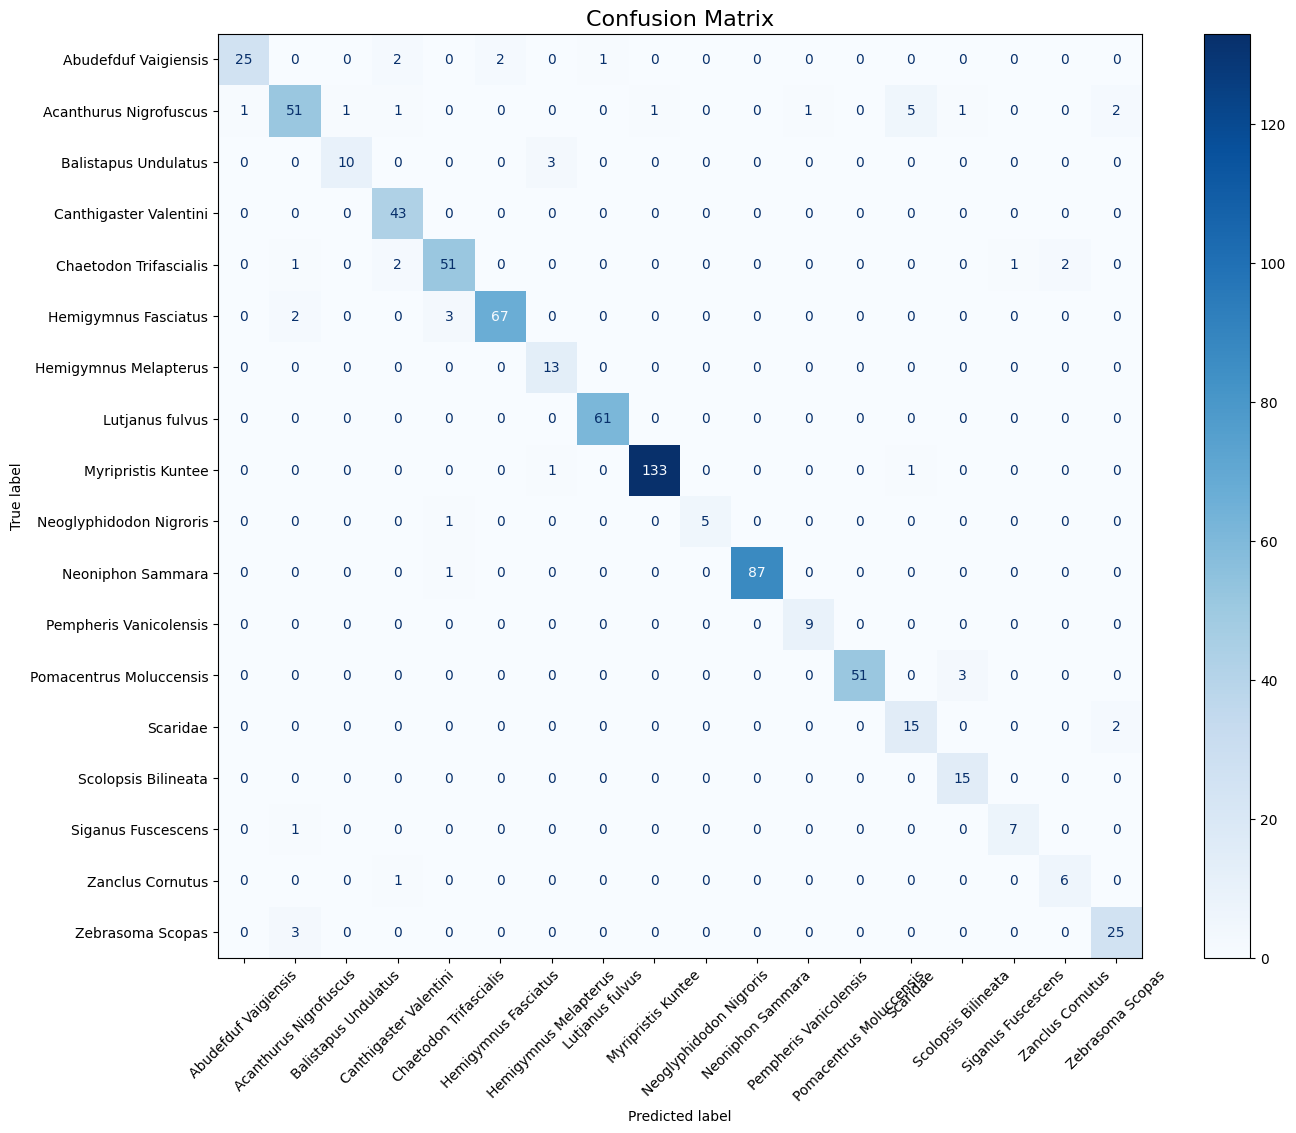

In [96]:
# NOT ENHANCED
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_baseline_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.96      0.87      0.91        30
 Acanthurus Nigrofuscus       0.85      0.89      0.87        64
   Balistapus Undulatus       1.00      0.77      0.87        13
 Canthigaster Valentini       0.88      0.98      0.92        43
 Chaetodon Trifascialis       0.93      0.91      0.92        57
   Hemigymnus Fasciatus       0.96      0.92      0.94        72
  Hemigymnus Melapterus       0.92      0.92      0.92        13
        Lutjanus fulvus       1.00      1.00      1.00        61
     Myripristis Kuntee       0.99      0.99      0.99       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       0.98      1.00      0.99        54
               Scaridae       0.79      0.88      0.83        17


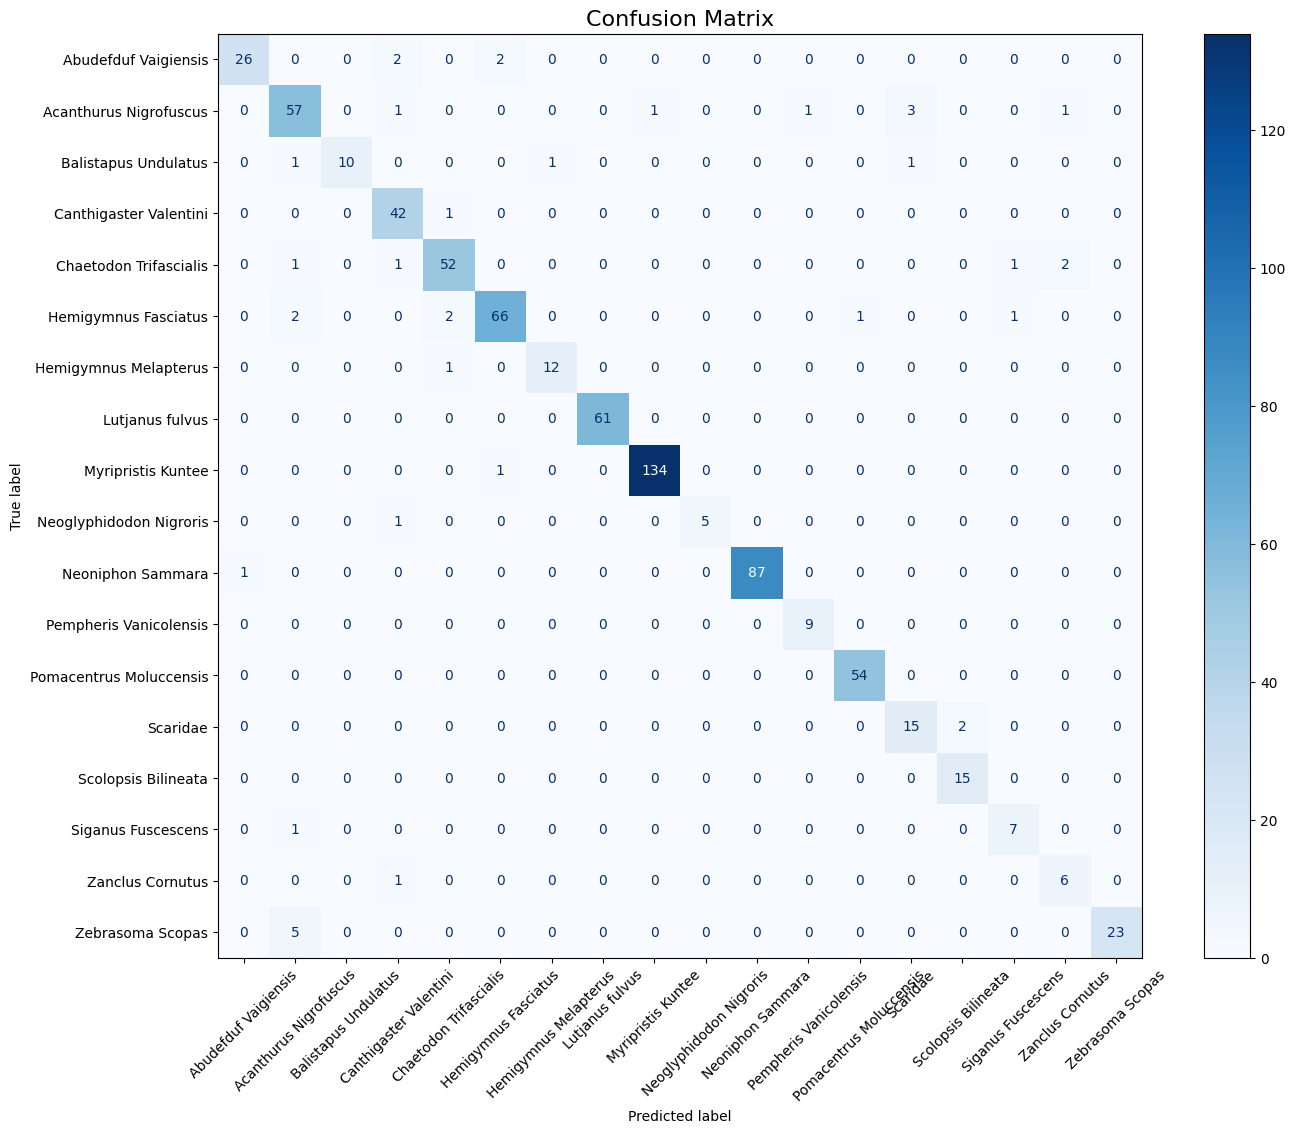

In [94]:
# ENHANCED
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.93      0.90      0.92        30
 Acanthurus Nigrofuscus       0.94      0.77      0.84        64
   Balistapus Undulatus       0.75      0.92      0.83        13
 Canthigaster Valentini       0.91      1.00      0.96        43
 Chaetodon Trifascialis       0.92      0.86      0.89        57
   Hemigymnus Fasciatus       0.99      0.92      0.95        72
  Hemigymnus Melapterus       0.67      0.92      0.77        13
        Lutjanus fulvus       0.98      0.95      0.97        61
     Myripristis Kuntee       0.99      0.98      0.98       135
Neoglyphidodon Nigroris       0.50      0.67      0.57         6
      Neoniphon Sammara       1.00      1.00      1.00        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       1.00      0.98      0.99        54
               Scaridae       0.80      0.94      0.86        17


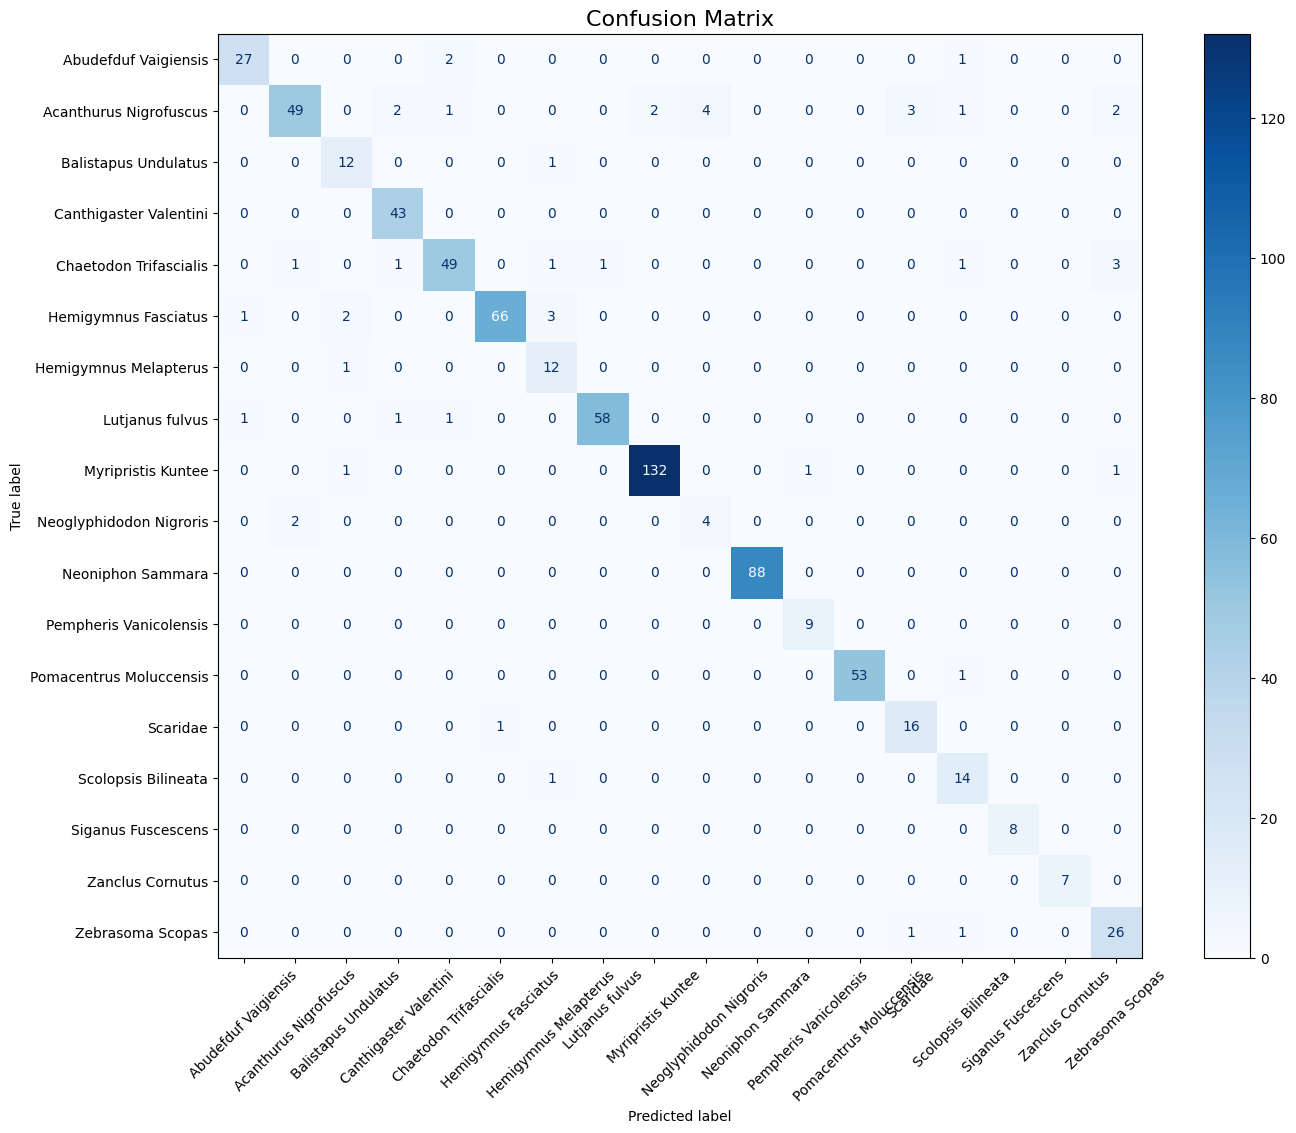

In [18]:
# ENHANCED + UNET
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

# Customize axis label sizes for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

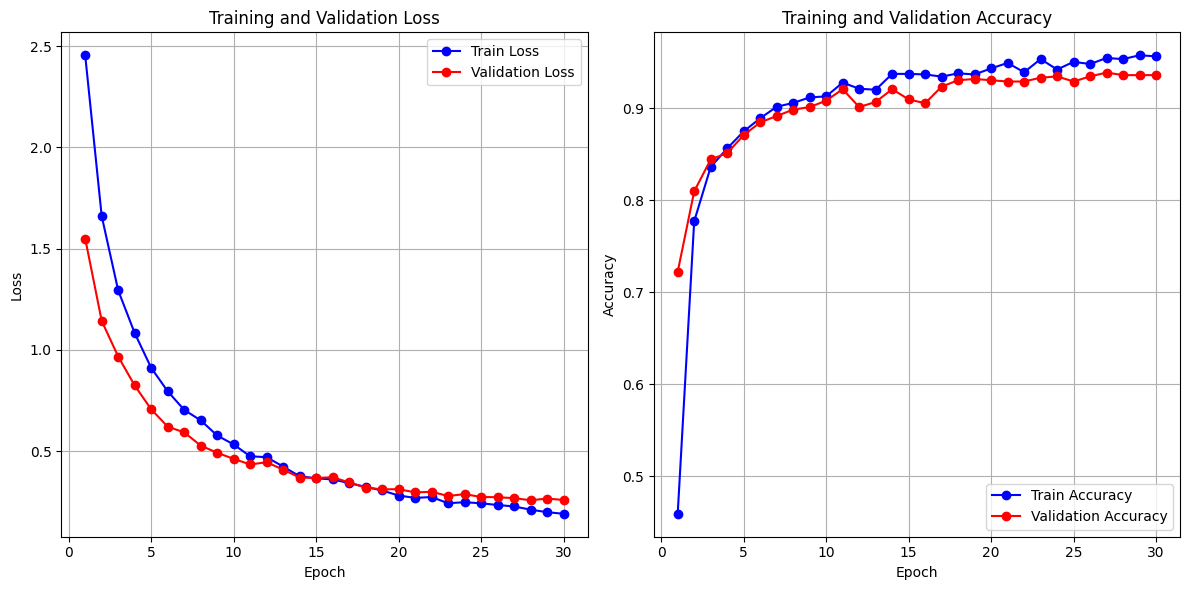

In [ ]:
loaded_history = load_history_from_csv('./saved_models/history/FINAL_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv')
# NOT ENHANCED
plot_from_history(loaded_history, max_epochs=30) # use loaded history for csv

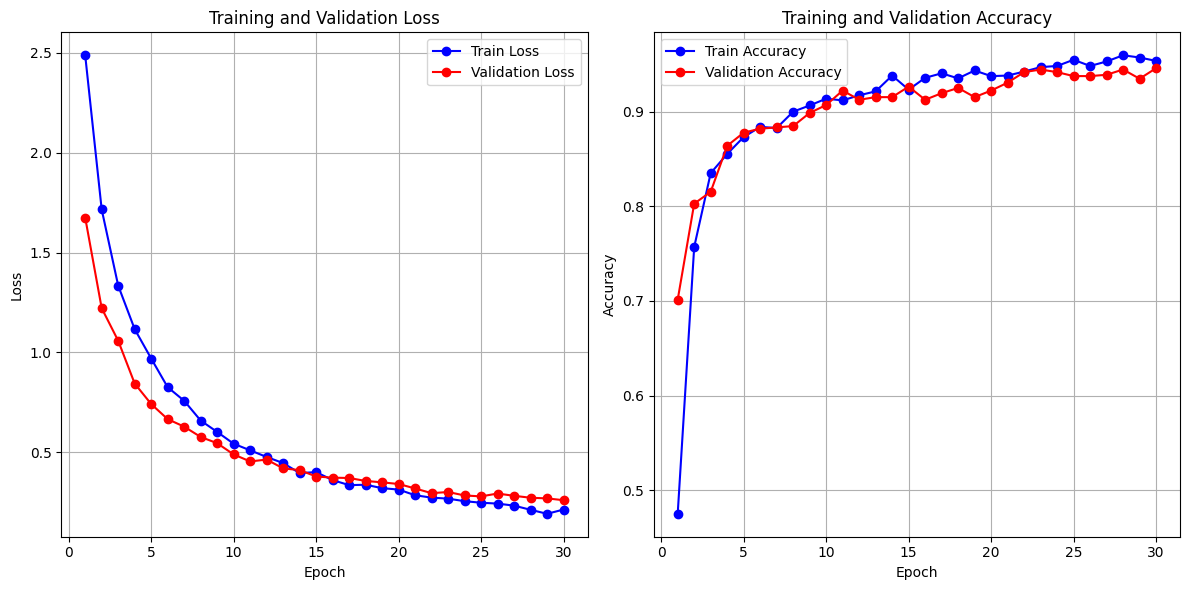

In [ ]:
loaded_history = load_history_from_csv('./saved_models/history/FINAL_torch_history_baselineb16notauglr001ENHANCEDtraintime_freezeAllEpoch30withclassweights.csv')
# ENHANCED
plot_from_history(loaded_history, max_epochs=30) # use loaded history for csv

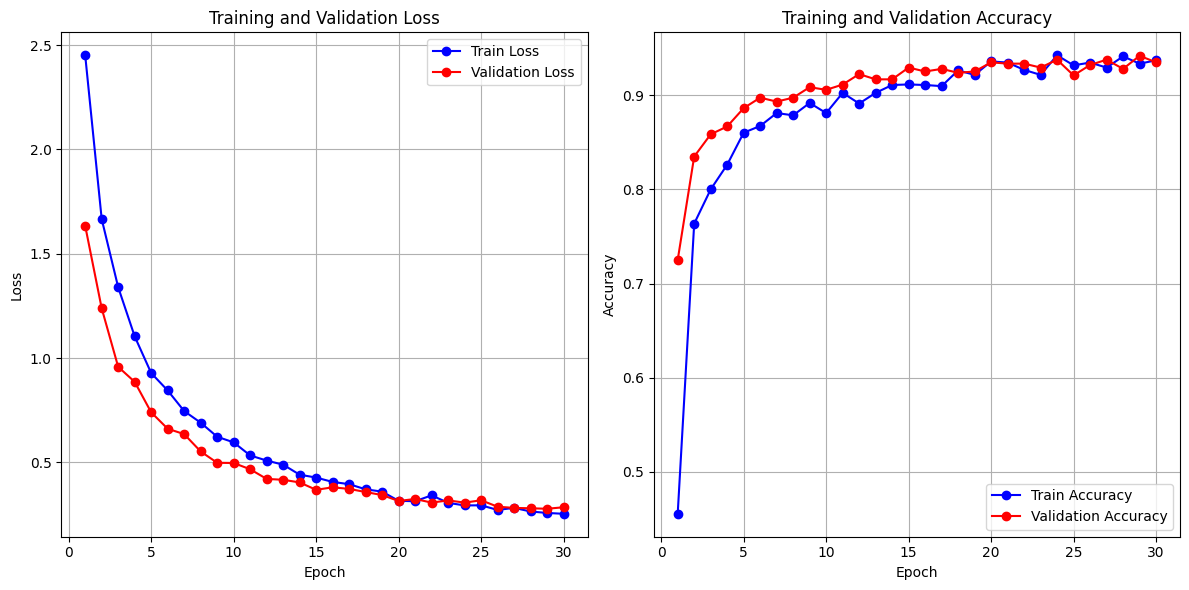

In [ ]:
# loaded_history = load_history_from_csv('./saved_models/history/FINAL_torch_history_baselineb16notauglr001ENHANCEDwUNETtraintime_freezeAllEpoch30withclassweights.csv')
# ENHANCED + UNET
plot_from_history(baseline_history, max_epochs=30) # use loaded history for csv

In [ ]:
# TEST ON SAMPLE IMAGE LIKE GRAPH

class_labels = train_dataset.classes
print(class_labels)

random_path = './sample_images/SAMPLE_LUTJANUS.jpg' # change dir to any image in Directory
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_baseline_model, random_path, device, class_labels)

predicted_class_label = predicted_class

print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


**===============Save Model=============**

In [ ]:
# CHANGE FILE NAME

df = pd.DataFrame(baseline_history)
df.to_csv('./saved_models/PREFINAL/history/FINAL_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv', index=False)
torch.save(torch_baseline_model, './saved_models/PREFINAL/model/FINAL_torch_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')
torch.save(torch_baseline_model.state_dict(), './saved_models/PREFINAL/weights/FINAL_torch_weights_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')

**===============LOAD Model=============**

In [9]:
torch_baseline_model.load_state_dict(torch.load('./saved_models/weights/FINAL_torch_weights_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [10]:
input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor
traced_model = torch.jit.trace(torch_baseline_model, input_tensor)

traced_model.save("./saved_models/weights/FINAL_torch_fullmodel_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pt")

# PYTORCH (PROPOSED)

In [11]:
learning_rate = 0.001
epochs = 30

torch_proposed = resnet50(weights="IMAGENET1K_V1").to(device)

# FREEZE ALL LAYERS
for name, layer in torch_proposed.named_modules():
    for param in layer.parameters():
        param.requires_grad = False

class ProposedResNet(nn.Module):
    def __init__(self, base_model, num_classes=18, dropout_rate=0.25): # Dropout rate is now .25 not .20
        super(ProposedResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.gmp = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(4096, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        gmp = self.gmp(x).view(x.size(0), -1)
        concat = torch.cat((gap, gmp), dim=1)
        concat = self.dropout(concat)
        x = self.fc(concat)
        return x


torch_proposed_model = ProposedResNet(torch_proposed).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # add to docs about using balanced class weights for imbalanced dataset refer at Function in Import section
optimizer = optim.Adamax(torch_proposed_model.fc.parameters(), lr=learning_rate)


for name, layer in torch_proposed_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [ ]:
# NOT ENHANCED Dropout rate .25 no augment 70:30 split
proposed_history = train_and_validate(torch_proposed_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.46it/s]


=> Train Loss=3.2879, Val Loss=1.5134 |  Train Acc=0.3532,  Val Acc=0.6292
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.45it/s]


=> Train Loss=1.4981, Val Loss=0.8352 |  Train Acc=0.6760,  Val Acc=0.8083
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.37it/s]


=> Train Loss=1.1034, Val Loss=0.7473 |  Train Acc=0.7367,  Val Acc=0.8097
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.38it/s]


=> Train Loss=0.7566, Val Loss=0.5583 |  Train Acc=0.8249,  Val Acc=0.8625
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.48it/s]


=> Train Loss=0.6294, Val Loss=0.4978 |  Train Acc=0.8582,  Val Acc=0.8861
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.38it/s]


=> Train Loss=0.5208, Val Loss=0.4669 |  Train Acc=0.8767,  Val Acc=0.8722
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.96it/s]


=> Train Loss=0.4928, Val Loss=0.4814 |  Train Acc=0.8779,  Val Acc=0.8667
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.36it/s]


=> Train Loss=0.4452, Val Loss=0.3650 |  Train Acc=0.8898,  Val Acc=0.8986
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.38it/s]


=> Train Loss=0.3931, Val Loss=0.3472 |  Train Acc=0.8999,  Val Acc=0.9028
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.43it/s]


=> Train Loss=0.3732, Val Loss=0.3541 |  Train Acc=0.8999,  Val Acc=0.8917
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.28it/s]


=> Train Loss=0.3046, Val Loss=0.3204 |  Train Acc=0.9083,  Val Acc=0.9111
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.41it/s]


=> Train Loss=0.2874, Val Loss=0.2988 |  Train Acc=0.9196,  Val Acc=0.9097
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.52it/s]


=> Train Loss=0.2745, Val Loss=0.2914 |  Train Acc=0.9250,  Val Acc=0.9125
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.50it/s]


=> Train Loss=0.2798, Val Loss=0.2889 |  Train Acc=0.9196,  Val Acc=0.9139
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.40it/s]


=> Train Loss=0.2301, Val Loss=0.2671 |  Train Acc=0.9327,  Val Acc=0.9264
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.49it/s]


=> Train Loss=0.1972, Val Loss=0.2729 |  Train Acc=0.9464,  Val Acc=0.9097
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.30it/s]


=> Train Loss=0.2107, Val Loss=0.2350 |  Train Acc=0.9434,  Val Acc=0.9417
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.53it/s]


=> Train Loss=0.2235, Val Loss=0.2431 |  Train Acc=0.9303,  Val Acc=0.9319
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.41it/s]


=> Train Loss=0.1833, Val Loss=0.2681 |  Train Acc=0.9440,  Val Acc=0.9250
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.53it/s]


=> Train Loss=0.1727, Val Loss=0.2561 |  Train Acc=0.9440,  Val Acc=0.9347
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.24it/s]


=> Train Loss=0.1653, Val Loss=0.2641 |  Train Acc=0.9470,  Val Acc=0.9236
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.48it/s]


=> Train Loss=0.1566, Val Loss=0.2797 |  Train Acc=0.9547,  Val Acc=0.9181
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.52it/s]


=> Train Loss=0.1700, Val Loss=0.2459 |  Train Acc=0.9506,  Val Acc=0.9153
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.36it/s]


=> Train Loss=0.1358, Val Loss=0.2630 |  Train Acc=0.9577,  Val Acc=0.9250
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.41it/s]


=> Train Loss=0.1589, Val Loss=0.3121 |  Train Acc=0.9470,  Val Acc=0.9167
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.52it/s]


=> Train Loss=0.1720, Val Loss=0.2611 |  Train Acc=0.9458,  Val Acc=0.9292
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.53it/s]


=> Train Loss=0.1343, Val Loss=0.2121 |  Train Acc=0.9607,  Val Acc=0.9403
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.49it/s]


=> Train Loss=0.1225, Val Loss=0.2258 |  Train Acc=0.9547,  Val Acc=0.9361
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.45it/s]


=> Train Loss=0.1406, Val Loss=0.2362 |  Train Acc=0.9518,  Val Acc=0.9292
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:09<00:00,  4.52it/s]

=> Train Loss=0.1228, Val Loss=0.1948 |  Train Acc=0.9583,  Val Acc=0.9472


In [ ]:
# ENHANCED Dropout rate .25 ENHANCED no augment 70:30 split
proposed_history = train_and_validate(torch_proposed_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.18it/s]


=> Train Loss=3.2422, Val Loss=1.4795 |  Train Acc=0.3621,  Val Acc=0.6472
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.25it/s]


=> Train Loss=1.4826, Val Loss=0.8370 |  Train Acc=0.6814,  Val Acc=0.8083
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.25it/s]


=> Train Loss=1.0933, Val Loss=0.7545 |  Train Acc=0.7427,  Val Acc=0.8208
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


=> Train Loss=0.7563, Val Loss=0.5712 |  Train Acc=0.8314,  Val Acc=0.8528
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.25it/s]


=> Train Loss=0.6248, Val Loss=0.5224 |  Train Acc=0.8582,  Val Acc=0.8792
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.24it/s]


=> Train Loss=0.5200, Val Loss=0.4743 |  Train Acc=0.8779,  Val Acc=0.8583
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.23it/s]


=> Train Loss=0.5063, Val Loss=0.5146 |  Train Acc=0.8749,  Val Acc=0.8569
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.23it/s]


=> Train Loss=0.4455, Val Loss=0.3628 |  Train Acc=0.8851,  Val Acc=0.8972
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.23it/s]


=> Train Loss=0.3967, Val Loss=0.3577 |  Train Acc=0.9011,  Val Acc=0.8972
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


=> Train Loss=0.3808, Val Loss=0.3588 |  Train Acc=0.8916,  Val Acc=0.8931
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.08it/s]


=> Train Loss=0.3079, Val Loss=0.3186 |  Train Acc=0.9124,  Val Acc=0.9181
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.13it/s]


=> Train Loss=0.2927, Val Loss=0.2996 |  Train Acc=0.9238,  Val Acc=0.9139
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


=> Train Loss=0.2727, Val Loss=0.2858 |  Train Acc=0.9285,  Val Acc=0.9194
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


=> Train Loss=0.2750, Val Loss=0.2770 |  Train Acc=0.9202,  Val Acc=0.9250
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


=> Train Loss=0.2291, Val Loss=0.2556 |  Train Acc=0.9333,  Val Acc=0.9264
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


=> Train Loss=0.2057, Val Loss=0.2634 |  Train Acc=0.9452,  Val Acc=0.9264
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


=> Train Loss=0.2166, Val Loss=0.2452 |  Train Acc=0.9398,  Val Acc=0.9278
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.2273, Val Loss=0.2460 |  Train Acc=0.9321,  Val Acc=0.9361
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.25it/s]


=> Train Loss=0.1823, Val Loss=0.2760 |  Train Acc=0.9482,  Val Acc=0.9222
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.1757, Val Loss=0.2643 |  Train Acc=0.9488,  Val Acc=0.9319
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.1695, Val Loss=0.2459 |  Train Acc=0.9464,  Val Acc=0.9292
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


=> Train Loss=0.1557, Val Loss=0.2518 |  Train Acc=0.9494,  Val Acc=0.9361
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.28it/s]


=> Train Loss=0.1750, Val Loss=0.2850 |  Train Acc=0.9452,  Val Acc=0.9014
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.1384, Val Loss=0.2668 |  Train Acc=0.9524,  Val Acc=0.9347
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.28it/s]


=> Train Loss=0.1662, Val Loss=0.3008 |  Train Acc=0.9404,  Val Acc=0.9111
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


=> Train Loss=0.1724, Val Loss=0.2525 |  Train Acc=0.9476,  Val Acc=0.9208
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.1301, Val Loss=0.2028 |  Train Acc=0.9577,  Val Acc=0.9514
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


=> Train Loss=0.1135, Val Loss=0.2214 |  Train Acc=0.9649,  Val Acc=0.9319
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


=> Train Loss=0.1564, Val Loss=0.2506 |  Train Acc=0.9482,  Val Acc=0.9278
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]

=> Train Loss=0.1183, Val Loss=0.1953 |  Train Acc=0.9631,  Val Acc=0.9500


In [ ]:
# ENHANCED + UNET Dropout rate .25 ENHANCED + UNET no augment 70:30 split
proposed_history = train_and_validate(torch_proposed_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.24it/s]


=> Train Loss=3.1863, Val Loss=1.3695 |  Train Acc=0.3943,  Val Acc=0.6736
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.25it/s]


=> Train Loss=1.3549, Val Loss=0.7524 |  Train Acc=0.6861,  Val Acc=0.8417
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.9746, Val Loss=0.6347 |  Train Acc=0.7528,  Val Acc=0.8528
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.25it/s]


=> Train Loss=0.7421, Val Loss=0.4861 |  Train Acc=0.8094,  Val Acc=0.8903
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


=> Train Loss=0.5903, Val Loss=0.4379 |  Train Acc=0.8612,  Val Acc=0.9069
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


=> Train Loss=0.4846, Val Loss=0.3700 |  Train Acc=0.8660,  Val Acc=0.9014
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]


=> Train Loss=0.4605, Val Loss=0.3821 |  Train Acc=0.8731,  Val Acc=0.8917
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.25it/s]


=> Train Loss=0.4477, Val Loss=0.3057 |  Train Acc=0.8743,  Val Acc=0.9181
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


=> Train Loss=0.3833, Val Loss=0.2767 |  Train Acc=0.8904,  Val Acc=0.9278
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.24it/s]


=> Train Loss=0.3539, Val Loss=0.2925 |  Train Acc=0.8964,  Val Acc=0.9236
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:20<00:00,  2.17it/s]


=> Train Loss=0.3607, Val Loss=0.3480 |  Train Acc=0.8851,  Val Acc=0.9014
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.09it/s]


=> Train Loss=0.2868, Val Loss=0.2746 |  Train Acc=0.9136,  Val Acc=0.9236
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


=> Train Loss=0.2820, Val Loss=0.2394 |  Train Acc=0.9172,  Val Acc=0.9319
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


=> Train Loss=0.2739, Val Loss=0.2654 |  Train Acc=0.9130,  Val Acc=0.9264
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


=> Train Loss=0.2459, Val Loss=0.2311 |  Train Acc=0.9273,  Val Acc=0.9431
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.12it/s]


=> Train Loss=0.2085, Val Loss=0.2616 |  Train Acc=0.9315,  Val Acc=0.9292
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


=> Train Loss=0.2180, Val Loss=0.2056 |  Train Acc=0.9273,  Val Acc=0.9458
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


=> Train Loss=0.2195, Val Loss=0.2062 |  Train Acc=0.9256,  Val Acc=0.9403
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


=> Train Loss=0.1839, Val Loss=0.2462 |  Train Acc=0.9345,  Val Acc=0.9319
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


=> Train Loss=0.1946, Val Loss=0.2886 |  Train Acc=0.9345,  Val Acc=0.9222
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.1825, Val Loss=0.2090 |  Train Acc=0.9422,  Val Acc=0.9361
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


=> Train Loss=0.1887, Val Loss=0.1933 |  Train Acc=0.9375,  Val Acc=0.9431
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


=> Train Loss=0.1978, Val Loss=0.2192 |  Train Acc=0.9357,  Val Acc=0.9389
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


=> Train Loss=0.1659, Val Loss=0.1869 |  Train Acc=0.9458,  Val Acc=0.9472
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


=> Train Loss=0.1736, Val Loss=0.2360 |  Train Acc=0.9387,  Val Acc=0.9333
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


=> Train Loss=0.1679, Val Loss=0.2385 |  Train Acc=0.9428,  Val Acc=0.9403
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


=> Train Loss=0.1693, Val Loss=0.2039 |  Train Acc=0.9416,  Val Acc=0.9403
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.28it/s]


=> Train Loss=0.1646, Val Loss=0.2082 |  Train Acc=0.9416,  Val Acc=0.9444
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


=> Train Loss=0.1488, Val Loss=0.1948 |  Train Acc=0.9512,  Val Acc=0.9528
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:19<00:00,  2.27it/s]

=> Train Loss=0.1324, Val Loss=0.1896 |  Train Acc=0.9547,  Val Acc=0.9500


# PROPOSED RESULTS & VISUALIZATION


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.96      0.80      0.87        30
 Acanthurus Nigrofuscus       0.95      0.83      0.88        64
   Balistapus Undulatus       1.00      0.85      0.92        13
 Canthigaster Valentini       1.00      1.00      1.00        43
 Chaetodon Trifascialis       0.89      0.95      0.92        57
   Hemigymnus Fasciatus       0.86      0.96      0.91        72
  Hemigymnus Melapterus       0.92      0.92      0.92        13
        Lutjanus fulvus       1.00      1.00      1.00        61
     Myripristis Kuntee       0.97      0.99      0.98       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       1.00      1.00      1.00         9
Pomacentrus Moluccensis       0.98      1.00      0.99        54
               Scaridae       0.82      0.82      0.82        17


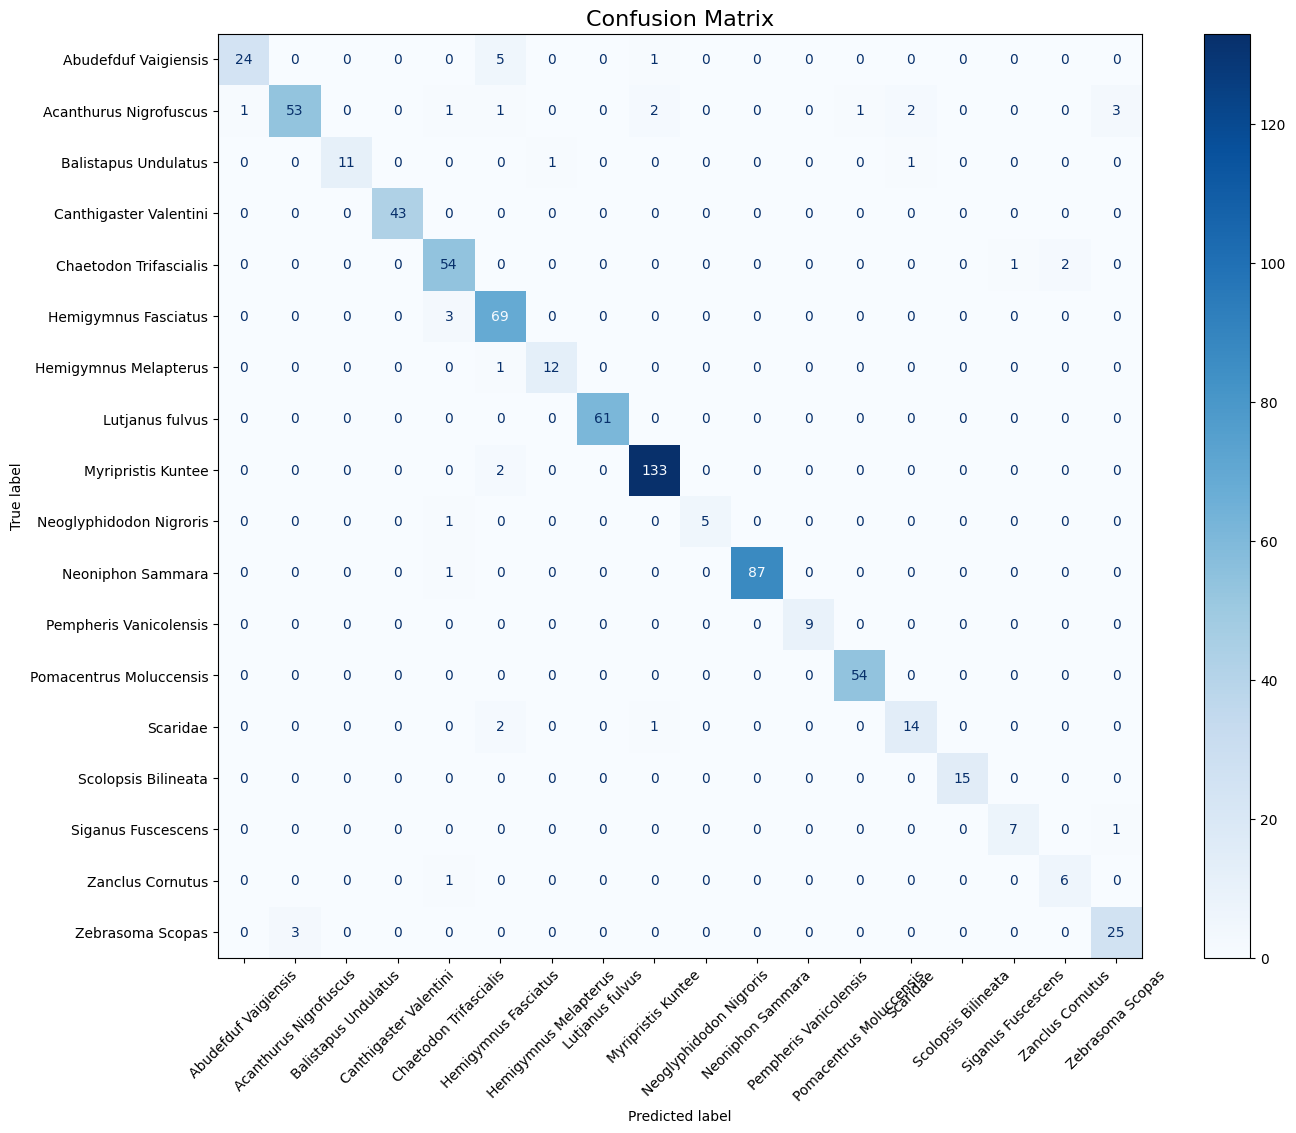

In [ ]:
# NOT ENHANCED
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_proposed_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.93      0.87      0.90        30
 Acanthurus Nigrofuscus       0.96      0.81      0.88        64
   Balistapus Undulatus       0.91      0.77      0.83        13
 Canthigaster Valentini       1.00      0.98      0.99        43
 Chaetodon Trifascialis       0.89      0.95      0.92        57
   Hemigymnus Fasciatus       0.91      0.93      0.92        72
  Hemigymnus Melapterus       0.80      0.92      0.86        13
        Lutjanus fulvus       1.00      1.00      1.00        61
     Myripristis Kuntee       0.99      0.99      0.99       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       1.00      1.00      1.00         9
Pomacentrus Moluccensis       0.98      1.00      0.99        54
               Scaridae       0.77      1.00      0.87        17


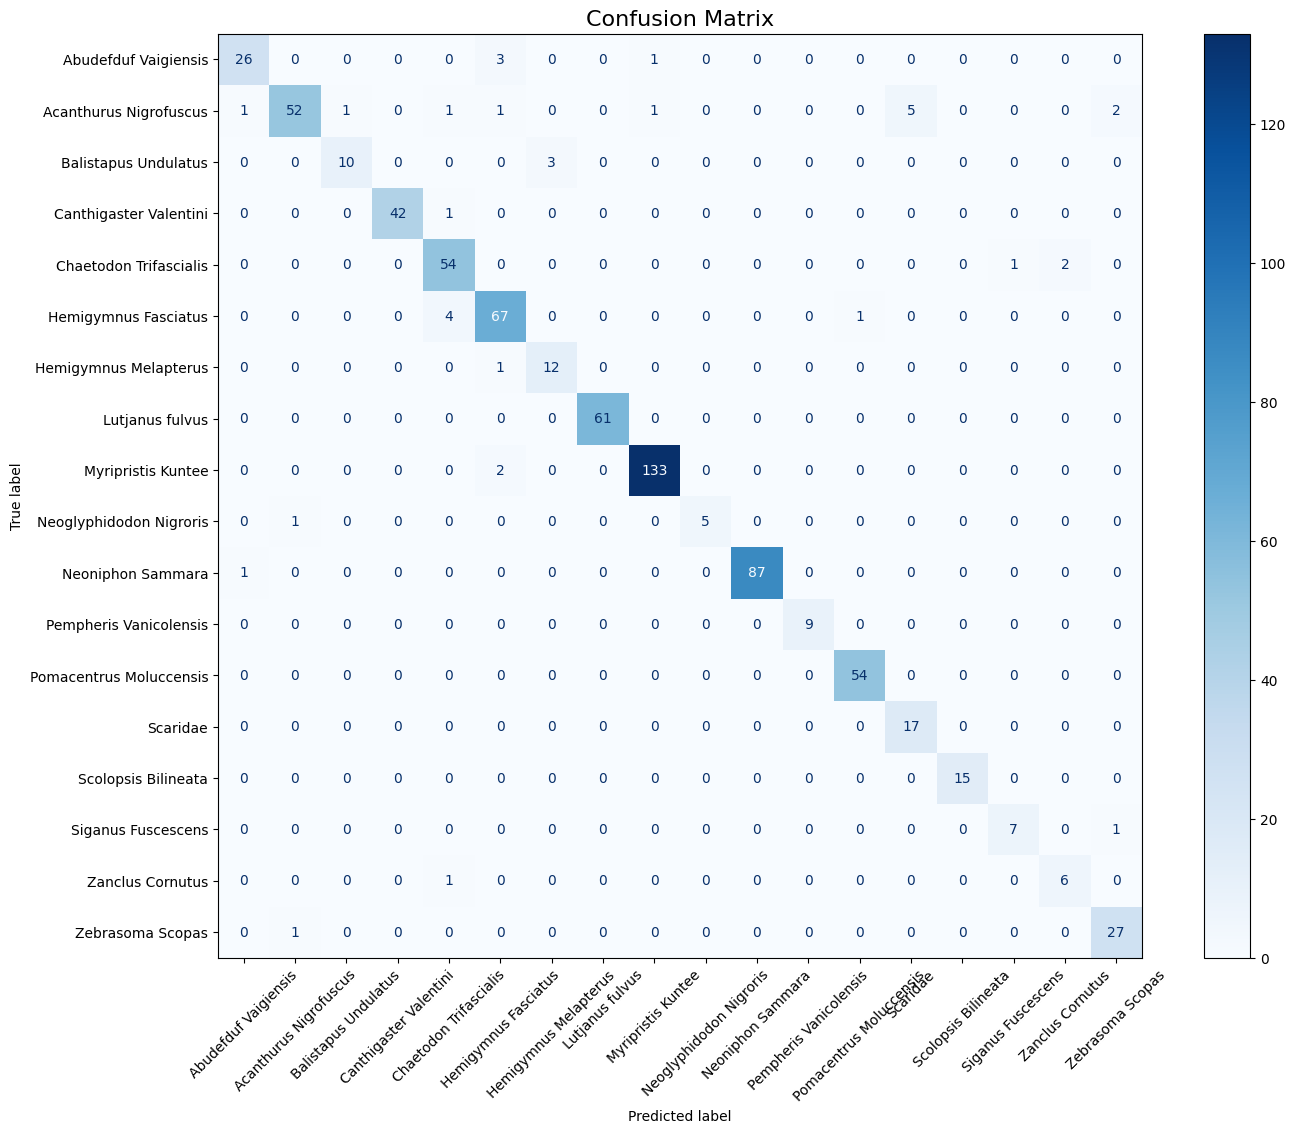

In [22]:
# ENHANCED
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_proposed_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.85      0.97      0.91        30
 Acanthurus Nigrofuscus       0.97      0.89      0.93        64
   Balistapus Undulatus       1.00      0.85      0.92        13
 Canthigaster Valentini       0.93      1.00      0.97        43
 Chaetodon Trifascialis       0.98      0.84      0.91        57
   Hemigymnus Fasciatus       0.97      0.93      0.95        72
  Hemigymnus Melapterus       0.55      0.85      0.67        13
        Lutjanus fulvus       0.97      0.95      0.96        61
     Myripristis Kuntee       0.97      1.00      0.99       135
Neoglyphidodon Nigroris       1.00      0.50      0.67         6
      Neoniphon Sammara       1.00      1.00      1.00        88
 Pempheris Vanicolensis       1.00      1.00      1.00         9
Pomacentrus Moluccensis       0.98      0.96      0.97        54
               Scaridae       1.00      0.94      0.97        17


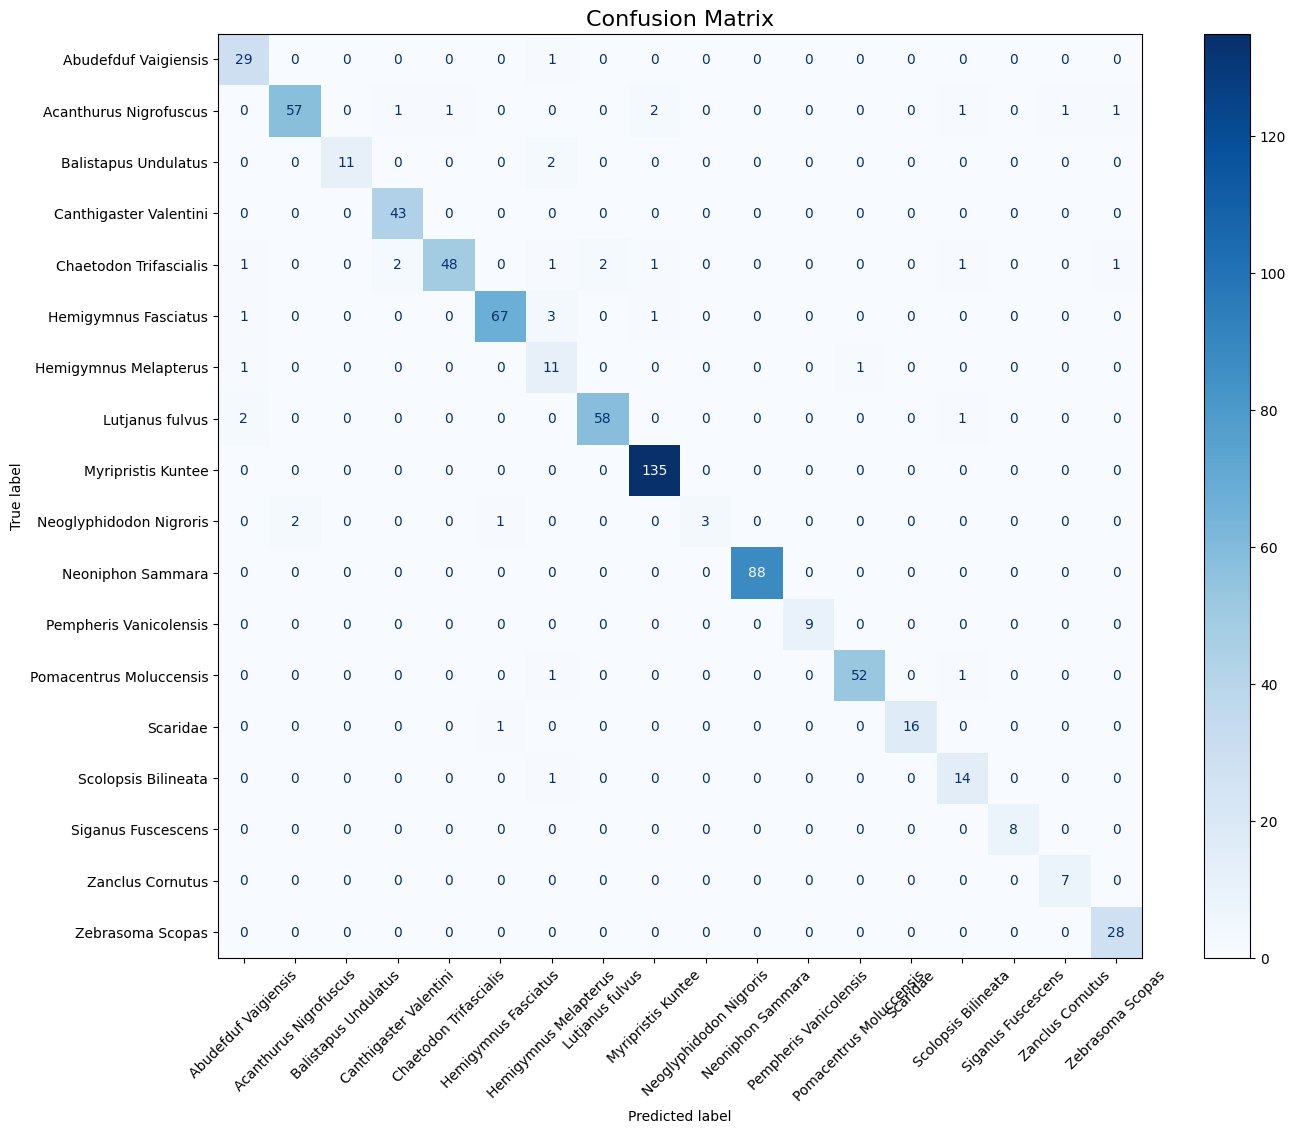

In [27]:
# ENHANCED + UNET
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = test_model(torch_proposed_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=plt.gca())

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

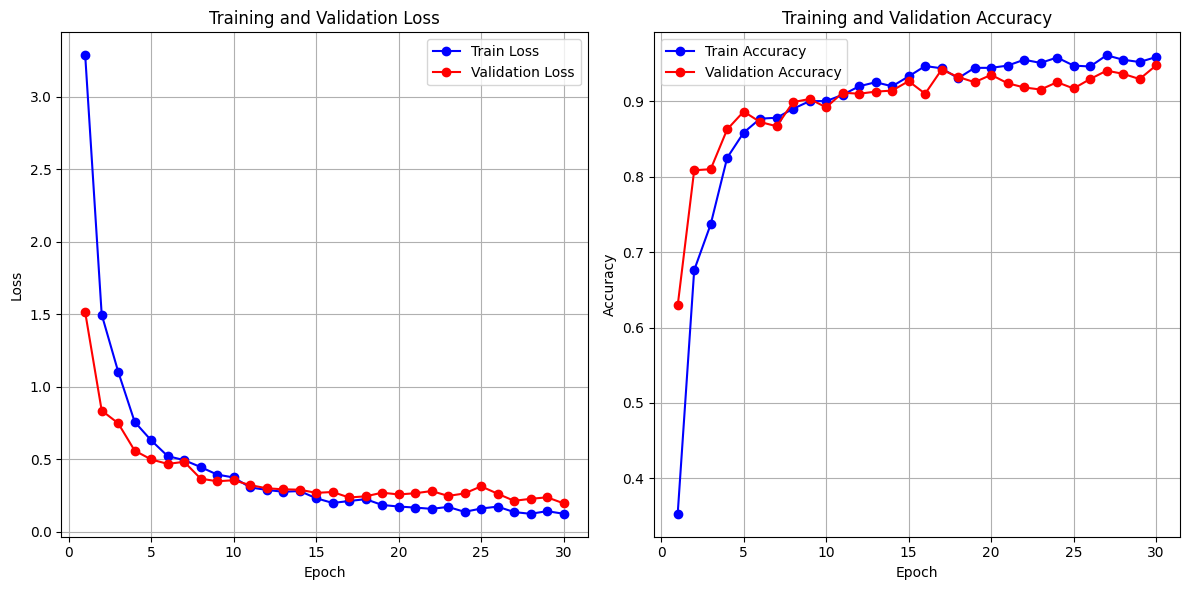

In [ ]:
# loaded_history = load_history_from_csv('./saved_models/history/FINAL_torch_history_proposedb16notauglr001notENHANCEDtraintime_freezeAllEpoch30withclassweights.csv')
# NOT ENHANCED 
plot_from_history(proposed_history, max_epochs=30) 

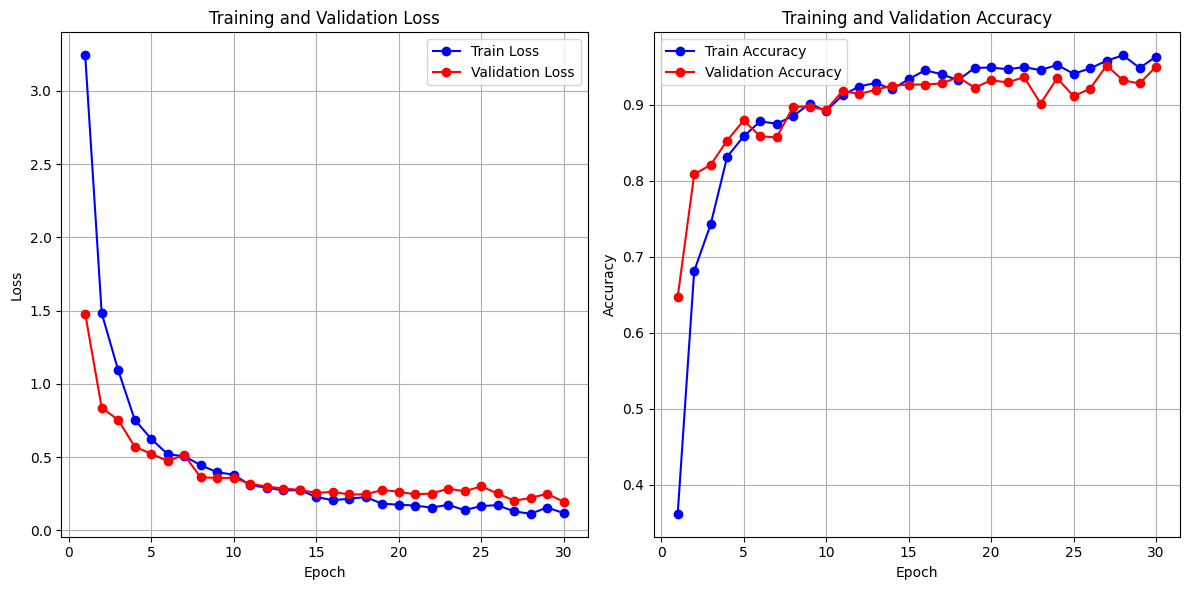

In [ ]:
# loaded_history = load_history_from_csv('./saved_models/history/FINAL_torch_history_proposedb16notauglr001ENHANCEDtraintime_freezeAllEpoch30withclassweights.csv')
# ENHANCED
plot_from_history(proposed_history, max_epochs=30) 

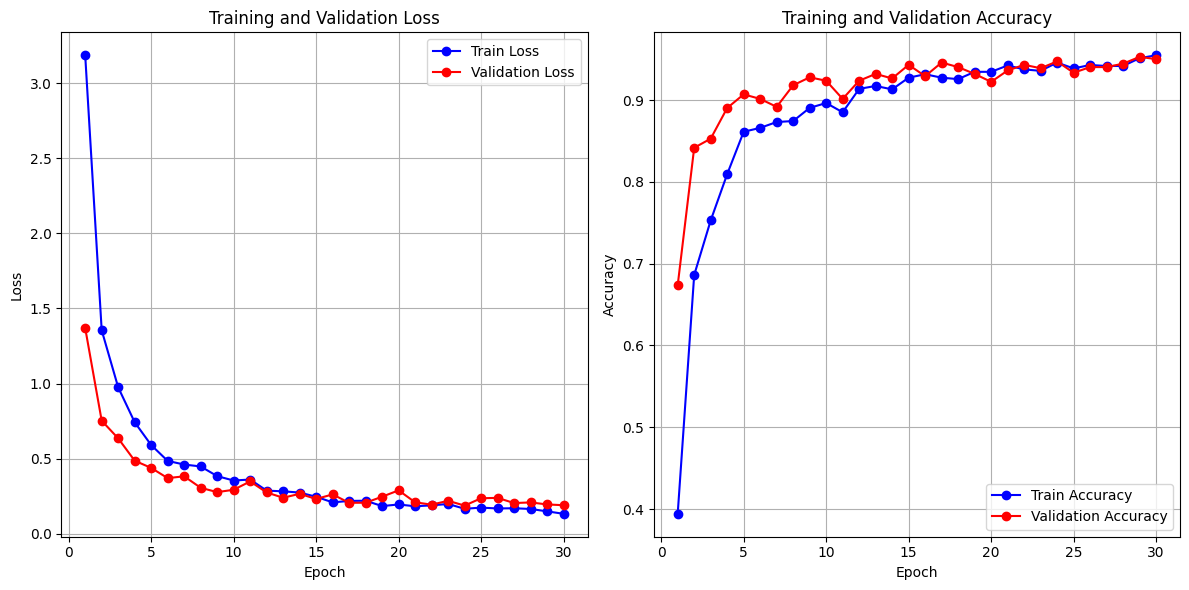

In [ ]:
# loaded_history = load_history_from_csv('./saved_models/history/FINAL_torch_history_proposedb16notauglr001ENHANCEDwUNETtraintime_freezeAllEpoch30withclassweights.csv')
# ENHANCED + UNET 
plot_from_history(proposed_history, max_epochs=30) 

**===============SAVE Model=============**

In [ ]:
# CHANGE FILENAME

df = pd.DataFrame(proposed_history)
df.to_csv('./saved_models/history/FINAL_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv', index=False)
torch.save(torch_proposed_model, './saved_models/model/FINAL_torch_proposedb16notauglr001notENHANCEDtraintime_freezeAllEpoch30withclassweights.pth')
torch.save(torch_proposed_model.state_dict(), './saved_models/weights/FINAL_torch_weights_proposedb16notauglr001notENHANCEDtraintime_freezeAllEpoch30withclassweights.pth')

**===============LOAD Model=============**

In [12]:
torch_proposed_model.load_state_dict(torch.load('./saved_models/weights/FINAL_torch_weights_proposedb16notauglr001ENHANCEDwUNETtraintime_freezeAllEpoch30withclassweights.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [13]:
input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor
traced_model = torch.jit.trace(torch_proposed_model, input_tensor)

traced_model.save("./saved_models/weights/FINAL_torch_fullmodel_proposedb16notauglr001ENHANCEDwUNETtraintime_freezeAllEpoch30withclassweights.pt")

/home/ken/personal/res-training/venv/lib64/python3.12/site-packages/torch/jit/_trace.py:1304: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 18 / 18 (100.0%)
Greatest absolute difference: 3.228689193725586 at index (0, 14) (up to 1e-05 allowed)
Greatest relative difference: 0.31406909262884436 at index (0, 14) (up to 1e-05 allowed)
  _check_trace(


# OTHER MODELS

In [9]:
# Model Definition
from torchvision.models import vgg16
torch.cuda.empty_cache()

torch_vgg_model = vgg16(weights="IMAGENET1K_V1")

# Modify the classifier to match the number of classes
torch_vgg_model.classifier[6] = nn.Linear(4096, 18)

# Freeze all layers except the classifier
for param in torch_vgg_model.features.parameters():
    param.requires_grad = False

# for name, param in torch_vgg_model.named_parameters():
#     print(f"Parameter: {name}, Trainable: {param.requires_grad}")

torch_vgg_model = torch_vgg_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adamax(torch_vgg_model.classifier.parameters(), lr=0.001)  

# Train the model
vgg_history = train_and_validate(torch_vgg_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=30)


=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:31<00:00,  1.45it/s]


=> Train Loss=1.4797, Val Loss=0.3678 |  Train Acc=0.7338,  Val Acc=0.8958
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:28<00:00,  1.56it/s]


=> Train Loss=0.2834, Val Loss=0.1881 |  Train Acc=0.9428,  Val Acc=0.9375
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


=> Train Loss=0.0797, Val Loss=0.1254 |  Train Acc=0.9845,  Val Acc=0.9681
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


=> Train Loss=0.0267, Val Loss=0.1143 |  Train Acc=0.9929,  Val Acc=0.9750
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


=> Train Loss=0.0098, Val Loss=0.1099 |  Train Acc=0.9982,  Val Acc=0.9694
=====================================Epoch: 6 / 30=====================================


  0%|          | 0/105 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(torch_vgg_model, "./saved_models/model/vgg16_full_model.pth")
torch.save(torch_vgg_model.state_dict(), "./saved_models/weights/vgg16_weights.pth")

In [ ]:
torch_vgg_model = torch.load("./saved_models/model/vgg16_full_model.pth")
torch_vgg_model.eval()  

# # Reinitialize the model
# torch_vgg_model = vgg16(weights="IMAGENET1K_V1")
# torch_vgg_model.classifier[6] = nn.Linear(4096, 18)  

# # Load state dictionary
# torch_vgg_model.load_state_dict(torch.load("vgg16_state_dict.pth"))

# torch_vgg_model = torch_vgg_model.to(device)
# torch_vgg_model.eval()  # Set model to evaluation mode

**INCEPTION**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_and_validate_inception(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5):

    for epoch in range(1, num_epochs + 1):
        print(f"=====================================Epoch: {epoch} / {num_epochs}=====================================")

        # Training phase
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        train_loader_iter = tqdm(train_loader, desc="[TRAIN]", leave=True)

        for inputs, targets in train_loader_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass
            if hasattr(model, "aux_logits") and model.aux_logits:  # Handle InceptionV3
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, targets)
                loss2 = criterion(aux_outputs, targets)
                loss = loss1 + 0.4 * loss2  # Weighted sum of primary and auxiliary loss
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            # Training metrics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        train_acc = correct_train / total_train
        train_loss /= total_train

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        val_loader_iter = tqdm(val_loader, desc="[VALID]", leave=False)

        with torch.no_grad():
            for inputs, targets in val_loader_iter:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)

        val_acc = correct_val / total_val
        val_loss /= total_val


        print(f"=> Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} |  Train Acc={train_acc:.4f},  Val Acc={val_acc:.4f}")


    return model


In [15]:
# Import necessary libraries
from torchvision.models import inception_v3

# Clear GPU cache
torch.cuda.empty_cache()

# Load pre-trained InceptionV3 model
torch_inception_model = inception_v3(weights="IMAGENET1K_V1")

# Modify the classifier for 18 classes
torch_inception_model.fc = nn.Linear(torch_inception_model.fc.in_features, 18)

if torch_inception_model.aux_logits:
    torch_inception_model.AuxLogits.fc = nn.Linear(torch_inception_model.AuxLogits.fc.in_features, 18)

# Freeze all layers except the classifier
for param in torch_inception_model.parameters():
    param.requires_grad = False

# Unfreeze classifier layers
for param in torch_inception_model.fc.parameters():
    param.requires_grad = True

if torch_inception_model.aux_logits:
    for param in torch_inception_model.AuxLogits.fc.parameters():
        param.requires_grad = True

# Move model to device
torch_inception_model = torch_inception_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(torch_inception_model.fc.parameters(), lr=0.001)

# Train the model
inception_history = train_and_validate_inception(torch_inception_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=5)


=====================================Epoch: 1 / 5=====================================


=> Train Loss=3.4345, Val Loss=1.8795 |  Train Acc=0.3633,  Val Acc=0.5722
=====================================Epoch: 2 / 5=====================================


=> Train Loss=2.9150, Val Loss=1.5273 |  Train Acc=0.6004,  Val Acc=0.7028
=====================================Epoch: 3 / 5=====================================


=> Train Loss=2.6292, Val Loss=1.3281 |  Train Acc=0.6867,  Val Acc=0.7111
=====================================Epoch: 4 / 5=====================================


=> Train Loss=2.4722, Val Loss=1.1992 |  Train Acc=0.6945,  Val Acc=0.7486
=====================================Epoch: 5 / 5=====================================


=> Train Loss=2.3473, Val Loss=1.0432 |  Train Acc=0.7219,  Val Acc=0.7542
Training complete! Best Val Acc: 0.7542


In [16]:
torch.save(torch_inception_model, "./saved_models/model/inception_model_5epoch.pth")
torch.save(torch_inception_model.state_dict(), "./saved_models/weights/inception_weights_5epoch.pth")


In [ ]:
torch_inception_model = torch.load("./saved_models/model/inception_model_5epoch.pth")
torch_inception_model.eval()  # Set to evaluation mode

# from torchvision.models import inception_v3

# # Load the InceptionV3 model architecture
# torch_inception_model = inception_v3(weights="IMAGENET1K_V1")

# # Modify the classifier for 18 classes
# torch_inception_model.fc = nn.Linear(torch_inception_model.fc.in_features, 18)

# if torch_inception_model.aux_logits:
#     torch_inception_model.AuxLogits.fc = nn.Linear(torch_inception_model.AuxLogits.fc.in_features, 18)

# # Load the saved weights
# torch_inception_model.load_state_dict(torch.load("inception_v3_weights.pth"))

# torch_inception_model.to(device)
# torch_inception_model.eval()  # Set to evaluation mode



**DENSENET**

In [5]:
def train_and_validate_densenet(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5):
    best_val_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f"=====================================Epoch: {epoch} / {num_epochs}=====================================")

        # Training phase
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        train_loader_iter = tqdm(train_loader, desc="[TRAIN]", leave=True)

        for inputs, targets in train_loader_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            # Training metrics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        train_acc = correct_train / total_train
        train_loss /= total_train

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        val_loader_iter = tqdm(val_loader, desc="[VALID]", leave=True)

        with torch.no_grad():
            for inputs, targets in val_loader_iter:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)

        val_acc = correct_val / total_val
        val_loss /= total_val

        # Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_densenet_model.pth")

        print(f"=> Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} |  Train Acc={train_acc:.4f},  Val Acc={val_acc:.4f}")

    print(f"Training complete! Best Val Acc: {best_val_acc:.4f}")

    return model


In [6]:
from torchvision import models

# Load DenseNet121 with pre-trained weights
torch_densenet_model = models.densenet121(weights="IMAGENET1K_V1")

# Modify the classifier to match the number of classes
num_features = torch_densenet_model.classifier.in_features
torch_densenet_model.classifier = nn.Linear(num_features, 18)  # Update classifier first

# Freeze all layers except the classifier
for param in torch_densenet_model.features.parameters():
    param.requires_grad = False  # Freezing feature extractor

# Move model to device
torch_densenet_model = torch_densenet_model.to(device)

# Define loss function and optimizer (only train classifier)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adamax(torch_densenet_model.classifier.parameters(), lr=0.001)

# Train the model
densenet_history = train_and_validate_densenet(torch_densenet_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=5)


=====================================Epoch: 1 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:10<00:00,  4.23it/s]


=> Train Loss=2.4828, Val Loss=1.7794 |  Train Acc=0.4753,  Val Acc=0.6972
=====================================Epoch: 2 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:12<00:00,  3.47it/s]


=> Train Loss=1.8542, Val Loss=1.4091 |  Train Acc=0.7635,  Val Acc=0.7736
=====================================Epoch: 3 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:12<00:00,  3.60it/s]


=> Train Loss=1.5508, Val Loss=1.2429 |  Train Acc=0.7987,  Val Acc=0.7861
=====================================Epoch: 4 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:12<00:00,  3.54it/s]


=> Train Loss=1.3188, Val Loss=1.0347 |  Train Acc=0.8451,  Val Acc=0.8361
=====================================Epoch: 5 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:14<00:00,  3.01it/s]

=> Train Loss=1.1766, Val Loss=0.9275 |  Train Acc=0.8654,  Val Acc=0.8444
Training complete! Best Val Acc: 0.8444


In [ ]:
torch.save(torch_densenet_model, "./saved_models/model/densenet_full_model_5epoch.pth")
torch.save(torch_densenet_model.state_dict(), "./saved_models/weights/densenet_weights.pth")


In [ ]:
densenet_model = torch.load("./saved_models/model/densenet_full_model_5epoch.pth")
densenet_model.eval()  

# torch_densenet_model = models.densenet121(weights="IMAGENET1K_V1")

# num_features = torch_densenet_model.classifier.in_features
# torch_densenet_model.classifier = nn.Linear(num_features, 18)

# # Load the saved weights
# torch_densenet_model.load_state_dict(torch.load("densenet_weights.pth"))

# # Move to device and set to evaluation mode
# torch_densenet_model = torch_densenet_model.to(device)
# torch_densenet_model.eval()



**MOBILENETv2**

In [12]:
def train_and_validate_mobilenet(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5):
    for epoch in range(1, num_epochs + 1):

        print(f"=====================================Epoch: {epoch} / {num_epochs}=====================================")
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        train_loader_iter = tqdm(train_loader, desc="[TRAIN]", leave=True)

        for inputs, targets in train_loader_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        train_acc = correct_train / total_train
        train_loss /= total_train

        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        val_loader_iter = tqdm(val_loader, desc="[VALID]", leave=True)

        with torch.no_grad():
            for inputs, targets in val_loader_iter:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)

        val_acc = correct_val / total_val
        val_loss /= total_val


        print(f"=> Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} |  Train Acc={train_acc:.4f},  Val Acc={val_acc:.4f}")


    return model


In [13]:
from torchvision.models import mobilenet_v2

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained MobileNetV2
mobilenet_model = mobilenet_v2(weights="IMAGENET1K_V1")

# Modify the classifier for custom classes (e.g., 18 classes)
num_classes = 18
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, num_classes)

# Move model to device
mobilenet_model = mobilenet_model.to(device)

# Freeze all layers except the classifier
for param in mobilenet_model.features.parameters():
    param.requires_grad = False

# Unfreeze classifier layers
for param in mobilenet_model.classifier.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adamax(mobilenet_model.classifier.parameters(), lr=0.001)


mobilenet_history = train_and_validate_mobilenet(mobilenet_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=5)

=====================================Epoch: 1 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:08<00:00,  5.03it/s]


=> Train Loss=2.4273, Val Loss=1.5427 |  Train Acc=0.5092,  Val Acc=0.7167
=====================================Epoch: 2 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:08<00:00,  5.15it/s]


=> Train Loss=1.6302, Val Loss=1.1728 |  Train Acc=0.7612,  Val Acc=0.8236
=====================================Epoch: 3 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:08<00:00,  5.12it/s]


=> Train Loss=1.3222, Val Loss=0.9880 |  Train Acc=0.8172,  Val Acc=0.8444
=====================================Epoch: 4 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:07<00:00,  5.94it/s]


=> Train Loss=1.0953, Val Loss=0.8598 |  Train Acc=0.8493,  Val Acc=0.8569
=====================================Epoch: 5 / 5=====================================


[VALID]: 100%|██████████| 45/45 [00:08<00:00,  5.04it/s]

=> Train Loss=0.9346, Val Loss=0.7230 |  Train Acc=0.8600,  Val Acc=0.8792


In [14]:
torch.save(mobilenet_model, "./saved_models/model/mobilenet_v2_model_5epoch.pth")
torch.save(mobilenet_model.state_dict(), "./saved_models/weights/mobilenet_v2_weights_5epoch.pth")


In [ ]:
mobilenet_model = torch.load("mobilenet_v2_model_5epoch.pth")
mobilenet_model.to(device)
mobilenet_model.eval()  # Set to evaluation mode


# mobilenet_model = mobilenet_v2(weights="IMAGENET1K_V1")

# # Modify classifier for 18 classes
# mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, 18)

# # Load saved weights
# mobilenet_model.load_state_dict(torch.load("mobilenet_v2_weights.pth"))

# mobilenet_model.to(device)
# mobilenet_model.eval()  # Set to evaluation mode
